In [1]:
import pandas as pd
import numpy as np
import re 

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from scipy.stats import shapiro
from scipy.stats import f_oneway
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%matplotlib inline
sns.set(font="Malgun Gothic",
        rc={"axes.unicode_minus":False}, style='white')
# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 사용할 한글 폰트 경로를 지정
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

## 0. 데이터 로드

In [3]:
data = pd.read_csv('신빅해_지역매핑데이터.csv')
data

,pk1,pk2,pk3,pk4,ba01m,ba02m,ba03r,ba04m,ba05r,ba06m,...,lf02r,lf03r,lf04r,lf05r,lf06r,lf07r,광역시도명,시군구명,구명,행정동명
0,2208,F,20s,11215760,3191000,654000,0.00,0,0.57,3256000,...,0.51,0.18,0.27,0.27,0.35,0.10,서울,광진구,NaN,중곡3동
1,2208,F,20s,11215770,3158000,1096000,0.00,0,0.45,3133000,...,0.62,0.13,0.28,0.15,0.46,0.10,서울,광진구,NaN,중곡4동
2,2208,F,20s,11215780,3534000,1184000,0.00,0,0.57,3456000,...,0.41,0.09,0.53,0.13,0.28,0.06,서울,광진구,NaN,능동
3,2208,F,20s,11215810,6868000,2161000,0.02,1116000,0.55,5308000,...,0.67,0.21,0.23,0.23,0.36,0.18,서울,광진구,NaN,광장동
4,2208,F,20s,11215820,3927000,929000,0.00,1000,0.57,3467000,...,0.47,0.11,0.42,0.15,0.38,0.05,서울,광진구,NaN,자양1동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114595,2306,F,60s,11650581,39548000,9006000,0.13,11905000,0.33,5614000,...,0.57,0.12,0.27,0.32,0.32,0.08,서울,서초구,NaN,반포4동
114596,2306,F,60s,11650590,32272000,8417000,0.06,6286000,0.23,7284000,...,0.61,0.12,0.27,0.35,0.29,0.10,서울,서초구,NaN,방배본동
114597,2306,F,60s,11650600,27868000,6406000,0.04,21157000,0.29,8423000,...,0.54,0.08,0.24,0.31,0.44,0.02,서울,서초구,NaN,방배1동
114598,2306,F,60s,11650610,19247000,4932000,0.03,23813000,0.21,7183000,...,0.56,0.12,0.34,0.26,0.32,0.08,서울,서초구,NaN,방배2동


In [4]:
# 연령대 생성
def transform_pk3(pk3):
    if pk3 in ['20e', '20s']:
        return '20'
    elif pk3 in ['30e', '30s']:
        return '30'
    elif pk3 in ['40e', '40s']:
        return '40'
    elif pk3 in ['50e', '50s']:
        return '50'
    elif pk3 in ['60e', '60s']:
        return '60'
    else:
        return pk3
    
data['pk3_age'] = data['pk3'].apply(transform_pk3)

data['region'] = data['광역시도명'] + ' ' + data['시군구명']
# 2030만 추출
# data = data[data['광역시도명']=='서울']
data = data[(data['pk3_age'] == '20') | (data['pk3_age'] == '30')]
data['group'] = data['pk2'] + ' ' + data['pk3'] + data['광역시도명']
data['pk4'] = data['pk4'].astype(str)

C:\Users\user\AppData\Local\Temp\ipykernel_18528\3415162981.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['group'] = data['pk2'] + ' ' + data['pk3'] + data['광역시도명']
C:\Users\user\AppData\Local\Temp\ipykernel_18528\3415162981.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pk4'] = data['pk4'].astype(str)


In [5]:
bank = data.iloc[:, :79].join(data.iloc[:, -7:])
bank['group'] = data['group']

card = data.iloc[:, [0, 1, 2, 3] + list(range(79, 277))]
card['group'] = data['group']
card['region'] = data['광역시도명']

invest = data.iloc[:, [0, 1, 2, 3] + list(range(277, 373))]
invest['group'] = data['group']

life = data.iloc[:, [0, 1, 2, 3] + list(range(373, 433))]
life['group'] = data['group']

C:\Users\user\AppData\Local\Temp\ipykernel_18528\1986365877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card['group'] = data['group']
C:\Users\user\AppData\Local\Temp\ipykernel_18528\1986365877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card['region'] = data['광역시도명']
C:\Users\user\AppData\Local\Temp\ipykernel_18528\1986365877.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

## 1. 다변량 회귀분석
### 1-1. 카드 데이터 결측치 처리
* 목적: 군집분석 변수 선정
* 신한카드 '여행' 관련 변수 기반 종속변수(y-value) 생성

In [6]:
card

,pk1,pk2,pk3,pk4,ca01m,ca02m,ca03r,cb01o,cb02o,cc01m,...,cg66r,ch01r,ch02r,ch03r,ch04r,ch05r,ch06r,ch07r,group,region
0,2208,F,20s,11215760,1159000.0,53.0,0.53,1.0,1.0,79000.0,...,0.05,0.76,0.32,0.08,0.18,0.53,0.24,0.05,F 20s서울,서울
1,2208,F,20s,11215770,1083000.0,46.0,0.47,1.0,4.0,99000.0,...,0.02,0.86,0.22,0.02,0.14,0.61,0.24,0.00,F 20s서울,서울
2,2208,F,20s,11215780,1501000.0,58.0,0.66,1.0,4.0,81000.0,...,0.12,0.83,0.29,0.02,0.15,0.56,0.29,0.00,F 20s서울,서울
3,2208,F,20s,11215810,1043000.0,50.0,0.44,1.0,1.0,156000.0,...,0.06,0.85,0.25,0.02,0.13,0.63,0.25,0.00,F 20s서울,서울
4,2208,F,20s,11215820,1213000.0,56.0,0.45,1.0,4.0,98000.0,...,0.12,0.89,0.18,0.03,0.11,0.70,0.18,0.02,F 20s서울,서울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113505,2306,M,20s,26260600,568000.0,21.0,0.20,1.0,4.0,6000.0,...,0.07,0.36,0.14,0.00,0.57,0.36,0.07,0.00,M 20s부산,부산
113506,2306,M,20s,26260740,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M 20s부산,부산
113507,2306,M,20s,26260750,1404000.0,71.0,0.70,1.0,1.0,380000.0,...,0.10,0.80,0.00,0.00,0.20,0.80,0.00,0.00,M 20s부산,부산
113508,2306,M,20s,26260761,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M 20s부산,부산


In [7]:
card_y = card[['pk2', 'pk3', 'pk4', 'region', 'ce33r', 'ce34r', 'ce35r', 'cg45r', 'cg46r', 'cg47r', 'cg66r']]
card_y

,pk2,pk3,pk4,region,ce33r,ce34r,ce35r,cg45r,cg46r,cg47r,cg66r
0,F,20s,11215760,서울,0.0,0.05,0.00,0.00,0.11,0.00,0.05
1,F,20s,11215770,서울,0.0,0.06,0.02,0.00,0.16,0.00,0.02
2,F,20s,11215780,서울,0.0,0.15,0.00,0.02,0.20,0.05,0.12
3,F,20s,11215810,서울,0.0,0.02,0.00,0.02,0.10,0.00,0.06
4,F,20s,11215820,서울,0.0,0.08,0.00,0.02,0.05,0.00,0.12
...,...,...,...,...,...,...,...,...,...,...,...
113505,M,20s,26260600,부산,0.0,0.07,0.00,0.00,0.14,0.00,0.07
113506,M,20s,26260740,부산,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113507,M,20s,26260750,부산,0.1,0.00,0.00,0.20,0.20,0.00,0.10
113508,M,20s,26260761,부산,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
card_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45840 entries, 0 to 113509
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pk2     45840 non-null  object 
 1   pk3     45840 non-null  object 
 2   pk4     45840 non-null  object 
 3   region  45840 non-null  object 
 4   ce33r   44175 non-null  float64
 5   ce34r   44175 non-null  float64
 6   ce35r   44175 non-null  float64
 7   cg45r   44175 non-null  float64
 8   cg46r   44175 non-null  float64
 9   cg47r   44175 non-null  float64
 10  cg66r   44175 non-null  float64
dtypes: float64(7), object(4)
memory usage: 5.2+ MB


In [9]:
# 지역별 결측치 많음
card_y.groupby('pk4').apply(lambda x: x.isnull().sum())

,pk2,pk3,pk4,region,ce33r,ce34r,ce35r,cg45r,cg46r,cg47r,cg66r
pk4,,,,,,,,,,,
11110515,0,0,0,0,4,4,4,4,4,4,4
11110530,0,0,0,0,4,4,4,4,4,4,4
11110540,0,0,0,0,16,16,16,16,16,16,16
11110550,0,0,0,0,6,6,6,6,6,6,6
11110560,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41500253,0,0,0,0,0,0,0,0,0,0,0
41570550,0,0,0,0,0,0,0,0,0,0,0
41590259,0,0,0,0,0,0,0,0,0,0,0


In [10]:
card_y.groupby('region').mean().reset_index()

,region,ce33r,ce34r,ce35r,cg45r,cg46r,cg47r,cg66r
0,경기,0.011166,0.050327,0.002311,0.006450,0.067073,0.001331,0.085444
1,광주,0.008520,0.048922,0.003964,0.005107,0.061204,0.000823,0.060288
2,대구,0.008449,0.088927,0.001597,0.008791,0.059001,0.000825,0.071396
3,대전,0.008073,0.110925,0.001760,0.006063,0.060395,0.000717,0.068848
4,부산,0.017715,0.060285,0.001747,0.010095,0.064537,0.001652,0.072600
5,서울,0.015568,0.063544,0.002192,0.012542,0.071729,0.001189,0.114630
6,울산,0.014169,0.061600,0.001431,0.014723,0.064369,0.023677,0.062831
7,인천,0.012738,0.031885,0.002851,0.006397,0.065318,0.001006,0.076992


In [11]:
# region을 기준으로 각 컬럼의 평균값 계산
# 대체하려는 컬럼 선택
selected_columns = ['ce33r', 'ce34r', 'ce35r', 'cg45r', 'cg46r', 'cg47r']

# 각 컬럼의 결측치를 해당 지역의 평균값으로 대체
for col in selected_columns:
    card_y[col].fillna(card_y.groupby('region')[col].transform('mean'), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_18528\1347442782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_y[col].fillna(card_y.groupby('region')[col].transform('mean'), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_18528\1347442782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_y[col].fillna(card_y.groupby('region')[col].transform('mean'), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_18528\1347442782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [12]:
card_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45840 entries, 0 to 113509
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pk2     45840 non-null  object 
 1   pk3     45840 non-null  object 
 2   pk4     45840 non-null  object 
 3   region  45840 non-null  object 
 4   ce33r   45840 non-null  float64
 5   ce34r   45840 non-null  float64
 6   ce35r   45840 non-null  float64
 7   cg45r   45840 non-null  float64
 8   cg46r   45840 non-null  float64
 9   cg47r   45840 non-null  float64
 10  cg66r   44175 non-null  float64
dtypes: float64(7), object(4)
memory usage: 5.2+ MB


In [13]:
# 연령대에 따른 cg66r 컬럼의 null값 존재
card_y.groupby('pk3').apply(lambda x: x.isnull().sum())

,pk2,pk3,pk4,region,ce33r,ce34r,ce35r,cg45r,cg46r,cg47r,cg66r
pk3,,,,,,,,,,,
20e,0,0,0,0,0,0,0,0,0,0,27
20s,0,0,0,0,0,0,0,0,0,0,1617
30e,0,0,0,0,0,0,0,0,0,0,11
30s,0,0,0,0,0,0,0,0,0,0,10


In [14]:
# pk3을 기준으로 각 컬럼의 평균값 계산
# 각 컬럼의 결측치를 해당 연령대의 평균값으로 대체
card_y['cg66r'].fillna(card_y.groupby('pk3')['cg66r'].transform('mean'), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_18528\1962550651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_y['cg66r'].fillna(card_y.groupby('pk3')['cg66r'].transform('mean'), inplace=True)


In [15]:
card_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45840 entries, 0 to 113509
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pk2     45840 non-null  object 
 1   pk3     45840 non-null  object 
 2   pk4     45840 non-null  object 
 3   region  45840 non-null  object 
 4   ce33r   45840 non-null  float64
 5   ce34r   45840 non-null  float64
 6   ce35r   45840 non-null  float64
 7   cg45r   45840 non-null  float64
 8   cg46r   45840 non-null  float64
 9   cg47r   45840 non-null  float64
 10  cg66r   45840 non-null  float64
dtypes: float64(7), object(4)
memory usage: 5.2+ MB


### 1-2. 타겟변수 생성

In [16]:
card

,pk1,pk2,pk3,pk4,ca01m,ca02m,ca03r,cb01o,cb02o,cc01m,...,cg66r,ch01r,ch02r,ch03r,ch04r,ch05r,ch06r,ch07r,group,region
0,2208,F,20s,11215760,1159000.0,53.0,0.53,1.0,1.0,79000.0,...,0.05,0.76,0.32,0.08,0.18,0.53,0.24,0.05,F 20s서울,서울
1,2208,F,20s,11215770,1083000.0,46.0,0.47,1.0,4.0,99000.0,...,0.02,0.86,0.22,0.02,0.14,0.61,0.24,0.00,F 20s서울,서울
2,2208,F,20s,11215780,1501000.0,58.0,0.66,1.0,4.0,81000.0,...,0.12,0.83,0.29,0.02,0.15,0.56,0.29,0.00,F 20s서울,서울
3,2208,F,20s,11215810,1043000.0,50.0,0.44,1.0,1.0,156000.0,...,0.06,0.85,0.25,0.02,0.13,0.63,0.25,0.00,F 20s서울,서울
4,2208,F,20s,11215820,1213000.0,56.0,0.45,1.0,4.0,98000.0,...,0.12,0.89,0.18,0.03,0.11,0.70,0.18,0.02,F 20s서울,서울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113505,2306,M,20s,26260600,568000.0,21.0,0.20,1.0,4.0,6000.0,...,0.07,0.36,0.14,0.00,0.57,0.36,0.07,0.00,M 20s부산,부산
113506,2306,M,20s,26260740,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M 20s부산,부산
113507,2306,M,20s,26260750,1404000.0,71.0,0.70,1.0,1.0,380000.0,...,0.10,0.80,0.00,0.00,0.20,0.80,0.00,0.00,M 20s부산,부산
113508,2306,M,20s,26260761,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M 20s부산,부산


In [17]:
card_y['group'] = card['pk2'] + ' ' + card['pk3'] + ' ' + card['region']
card_y

C:\Users\user\AppData\Local\Temp\ipykernel_18528\675232704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_y['group'] = card['pk2'] + ' ' + card['pk3'] + ' ' + card['region']


,pk2,pk3,pk4,region,ce33r,ce34r,ce35r,cg45r,cg46r,cg47r,cg66r,group
0,F,20s,11215760,서울,0.000000,0.050000,0.000000,0.000000,0.110000,0.000000,0.050000,F 20s 서울
1,F,20s,11215770,서울,0.000000,0.060000,0.020000,0.000000,0.160000,0.000000,0.020000,F 20s 서울
2,F,20s,11215780,서울,0.000000,0.150000,0.000000,0.020000,0.200000,0.050000,0.120000,F 20s 서울
3,F,20s,11215810,서울,0.000000,0.020000,0.000000,0.020000,0.100000,0.000000,0.060000,F 20s 서울
4,F,20s,11215820,서울,0.000000,0.080000,0.000000,0.020000,0.050000,0.000000,0.120000,F 20s 서울
...,...,...,...,...,...,...,...,...,...,...,...,...
113505,M,20s,26260600,부산,0.000000,0.070000,0.000000,0.000000,0.140000,0.000000,0.070000,M 20s 부산
113506,M,20s,26260740,부산,0.017715,0.060285,0.001747,0.010095,0.064537,0.001652,0.087961,M 20s 부산
113507,M,20s,26260750,부산,0.100000,0.000000,0.000000,0.200000,0.200000,0.000000,0.100000,M 20s 부산
113508,M,20s,26260761,부산,0.017715,0.060285,0.001747,0.010095,0.064537,0.001652,0.087961,M 20s 부산


In [18]:
# 결측값 drop
# card_y = card_y.dropna()
# card_y.info()
card_y.isna().sum()

pk2       0
pk3       0
pk4       0
region    0
ce33r     0
ce34r     0
ce35r     0
cg45r     0
cg46r     0
cg47r     0
cg66r     0
group     0
dtype: int64

In [19]:
card_y.columns

Index(['pk2', 'pk3', 'pk4', 'region', 'ce33r', 'ce34r', 'ce35r', 'cg45r',
       'cg46r', 'cg47r', 'cg66r', 'group'],
      dtype='object')

In [20]:
# 데이터프레임의 수치형 컬럼 선택
numeric_columns = ['ce33r', 'ce34r', 'ce35r', 'cg45r', 'cg46r','cg47r', 'cg66r']

In [21]:
card_y['여행 이용비율 합산'] = card_y[numeric_columns].sum(axis=1)
num_numeric_cols = len(numeric_columns)
card_y['여행 이용비율 (y)'] = card_y['여행 이용비율 합산'] / num_numeric_cols
card_y.head()

C:\Users\user\AppData\Local\Temp\ipykernel_18528\2317006180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_y['여행 이용비율 합산'] = card_y[numeric_columns].sum(axis=1)
C:\Users\user\AppData\Local\Temp\ipykernel_18528\2317006180.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  card_y['여행 이용비율 (y)'] = card_y['여행 이용비율 합산'] / num_numeric_cols


,pk2,pk3,pk4,region,ce33r,ce34r,ce35r,cg45r,cg46r,cg47r,cg66r,group,여행 이용비율 합산,여행 이용비율 (y)
0,F,20s,11215760,서울,0.0,0.05,0.00,0.00,0.11,0.00,0.05,F 20s 서울,0.21,0.030000
1,F,20s,11215770,서울,0.0,0.06,0.02,0.00,0.16,0.00,0.02,F 20s 서울,0.26,0.037143
2,F,20s,11215780,서울,0.0,0.15,0.00,0.02,0.20,0.05,0.12,F 20s 서울,0.54,0.077143
3,F,20s,11215810,서울,0.0,0.02,0.00,0.02,0.10,0.00,0.06,F 20s 서울,0.20,0.028571
4,F,20s,11215820,서울,0.0,0.08,0.00,0.02,0.05,0.00,0.12,F 20s 서울,0.27,0.038571


### 1-3. 독립변수 통계분석

In [22]:
bank

,pk1,pk2,pk3,pk4,ba01m,ba02m,ba03r,ba04m,ba05r,ba06m,...,be05r,be06r,be07r,광역시도명,시군구명,구명,행정동명,pk3_age,region,group
0,2208,F,20s,11215760,3191000,654000,0.00,0,0.57,3256000,...,0.69,0.14,0.02,서울,광진구,NaN,중곡3동,20,서울 광진구,F 20s서울
1,2208,F,20s,11215770,3158000,1096000,0.00,0,0.45,3133000,...,0.78,0.12,0.00,서울,광진구,NaN,중곡4동,20,서울 광진구,F 20s서울
2,2208,F,20s,11215780,3534000,1184000,0.00,0,0.57,3456000,...,0.74,0.15,0.01,서울,광진구,NaN,능동,20,서울 광진구,F 20s서울
3,2208,F,20s,11215810,6868000,2161000,0.02,1116000,0.55,5308000,...,0.69,0.19,0.01,서울,광진구,NaN,광장동,20,서울 광진구,F 20s서울
4,2208,F,20s,11215820,3927000,929000,0.00,1000,0.57,3467000,...,0.76,0.17,0.00,서울,광진구,NaN,자양1동,20,서울 광진구,F 20s서울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113505,2306,M,20s,26260600,1781000,636000,0.00,0,0.32,2721000,...,0.60,0.18,0.00,부산,동래구,NaN,사직3동,20,부산 동래구,M 20s부산
113506,2306,M,20s,26260740,2452000,602000,0.00,0,0.30,2486000,...,0.65,0.06,0.00,부산,동래구,NaN,안락1동,20,부산 동래구,M 20s부산
113507,2306,M,20s,26260750,2285000,464000,0.00,0,0.34,3656000,...,0.62,0.11,0.00,부산,동래구,NaN,안락2동,20,부산 동래구,M 20s부산
113508,2306,M,20s,26260761,1625000,316000,0.00,0,0.35,2743000,...,0.61,0.13,0.00,부산,동래구,NaN,명장1동,20,부산 동래구,M 20s부산


In [23]:
# 독립변수 
bank_x = bank.drop(columns=['pk1','광역시도명','시군구명','구명','행정동명','pk3_age',
                           'region'],  axis=1)
bank_x.head(3)

,pk2,pk3,pk4,ba01m,ba02m,ba03r,ba04m,ba05r,ba06m,ba07r,...,bd29r,bd30m,be01r,be02r,be03r,be04r,be05r,be06r,be07r,group
0,F,20s,11215760,3191000,654000,0.0,0,0.57,3256000,0.03,...,0.36,913000,0.85,0.17,0.02,0.15,0.69,0.14,0.02,F 20s서울
1,F,20s,11215770,3158000,1096000,0.0,0,0.45,3133000,0.03,...,0.34,822000,0.89,0.12,0.02,0.10,0.78,0.12,0.00,F 20s서울
2,F,20s,11215780,3534000,1184000,0.0,0,0.57,3456000,0.00,...,0.36,486000,0.90,0.15,0.03,0.09,0.74,0.15,0.01,F 20s서울


In [24]:
adj_cols = [col for col in bank_x.columns if col not in ['pk2', 'pk3', 'pk4', 'group']]

In [25]:
scaler = MinMaxScaler()
bank_scale = bank_x.copy()
cols_to_scale = [col for col in adj_cols if 'r' not in col] # '비율' 의미하는 컬럼 제외

bank_scale[cols_to_scale] = scaler.fit_transform(bank_scale[cols_to_scale])

In [26]:
bank_scale['group'] = bank_scale['pk2'] + ' ' + bank_scale['pk3'] + ' ' + bank['광역시도명']

In [27]:
bank_scale

,pk2,pk3,pk4,ba01m,ba02m,ba03r,ba04m,ba05r,ba06m,ba07r,...,bd29r,bd30m,be01r,be02r,be03r,be04r,be05r,be06r,be07r,group
0,F,20s,11215760,0.056117,0.015837,0.00,0.000000,0.57,0.062611,0.03,...,0.36,0.006613,0.85,0.17,0.02,0.15,0.69,0.14,0.02,F 20s 서울
1,F,20s,11215770,0.055519,0.026791,0.00,0.000000,0.45,0.059955,0.03,...,0.34,0.005954,0.89,0.12,0.02,0.10,0.78,0.12,0.00,F 20s 서울
2,F,20s,11215780,0.062326,0.028972,0.00,0.000000,0.57,0.066929,0.00,...,0.36,0.003520,0.90,0.15,0.03,0.09,0.74,0.15,0.01,F 20s 서울
3,F,20s,11215810,0.122678,0.053186,0.02,0.002904,0.55,0.106913,0.03,...,0.29,0.007786,0.86,0.20,0.02,0.12,0.69,0.19,0.01,F 20s 서울
4,F,20s,11215820,0.069440,0.022652,0.00,0.000003,0.57,0.067166,0.03,...,0.35,0.007656,0.93,0.17,0.01,0.07,0.76,0.17,0.00,F 20s 서울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113505,M,20s,26260600,0.030593,0.015391,0.00,0.000000,0.32,0.051060,0.02,...,0.14,0.001659,0.75,0.20,0.01,0.22,0.60,0.18,0.00,M 20s 부산
113506,M,20s,26260740,0.042739,0.014548,0.00,0.000000,0.30,0.045986,0.00,...,0.21,0.004592,0.66,0.08,0.02,0.29,0.65,0.06,0.00,M 20s 부산
113507,M,20s,26260750,0.039716,0.011128,0.00,0.000000,0.34,0.071247,0.01,...,0.16,0.003144,0.69,0.13,0.02,0.27,0.62,0.11,0.00,M 20s 부산
113508,M,20s,26260761,0.027769,0.007460,0.00,0.000000,0.35,0.051535,0.00,...,0.16,0.001688,0.74,0.13,0.00,0.26,0.61,0.13,0.00,M 20s 부산


In [28]:
bank_scale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45840 entries, 0 to 113509
Data columns (total 79 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pk2     45840 non-null  object 
 1   pk3     45840 non-null  object 
 2   pk4     45840 non-null  object 
 3   ba01m   45840 non-null  float64
 4   ba02m   45840 non-null  float64
 5   ba03r   45840 non-null  float64
 6   ba04m   45840 non-null  float64
 7   ba05r   45840 non-null  float64
 8   ba06m   45840 non-null  float64
 9   ba07r   45840 non-null  float64
 10  ba08m   45840 non-null  float64
 11  ba09r   45840 non-null  float64
 12  ba10m   45840 non-null  float64
 13  ba11r   45840 non-null  float64
 14  ba12m   45840 non-null  float64
 15  ba13r   45840 non-null  float64
 16  ba14m   45840 non-null  float64
 17  ba15r   45840 non-null  float64
 18  ba16m   45840 non-null  float64
 19  ba17r   45840 non-null  float64
 20  ba18m   45840 non-null  float64
 21  bb01r   45840 non-null  float64
 2

In [29]:
# 등분산 검정: Levene's test
levene_results = {}
for column in adj_cols:
    homoscedasticity_result = pg.homoscedasticity(bank_scale, dv=column, group='group')
    levene_results[column] = {'Levene Test p-value': homoscedasticity_result['pval'].values[0]}

print("등분산 검정 결과:")
for column, result in levene_results.items():
    print(f'{column}:')
    print(f'Levene Test p-value: {result["Levene Test p-value"]}')
    print('-' * 30)

등분산 검정 결과:
ba01m:
Levene Test p-value: 0.0
------------------------------
ba02m:
Levene Test p-value: 0.0
------------------------------
ba03r:
Levene Test p-value: 0.0
------------------------------
ba04m:
Levene Test p-value: 1.9846154898979806e-147
------------------------------
ba05r:
Levene Test p-value: 0.0
------------------------------
ba06m:
Levene Test p-value: 1.6575535977864413e-107
------------------------------
ba07r:
Levene Test p-value: 0.0
------------------------------
ba08m:
Levene Test p-value: 0.0
------------------------------
ba09r:
Levene Test p-value: 0.0
------------------------------
ba10m:
Levene Test p-value: 2.558554060634688e-66
------------------------------
ba11r:
Levene Test p-value: 0.0
------------------------------
ba12m:
Levene Test p-value: 8.852850197569054e-130
------------------------------
ba13r:
Levene Test p-value: 1.54237149478719e-309
------------------------------
ba14m:
Levene Test p-value: 3.109782445000246e-240
------------------------

In [30]:
# 정규성 검정: Shapiro-Wilk test
normality_results = {}
for column in adj_cols:
    shapiro_stat, shapiro_p = shapiro(bank_scale[column])
    normality_results[column] = {'Shapiro-Wilk Statistic': shapiro_stat, 'p-value': shapiro_p}

print("정규성 검정 결과:")
for column, result in normality_results.items():
    print(f'{column}:')
    print(f'Shapiro-Wilk Statistic: {result["Shapiro-Wilk Statistic"]}')
    print(f'p-value: {result["p-value"]}')
    print('-' * 30)

정규성 검정 결과:
ba01m:
Shapiro-Wilk Statistic: 0.8977758288383484
p-value: 0.0
------------------------------
ba02m:
Shapiro-Wilk Statistic: 0.8781196475028992
p-value: 0.0
------------------------------
ba03r:
Shapiro-Wilk Statistic: 0.6041063070297241
p-value: 0.0
------------------------------
ba04m:
Shapiro-Wilk Statistic: 0.2339106798171997
p-value: 0.0
------------------------------
ba05r:
Shapiro-Wilk Statistic: 0.9953721165657043
p-value: 3.353328372404672e-34
------------------------------
ba06m:
Shapiro-Wilk Statistic: 0.9573188424110413
p-value: 0.0
------------------------------
ba07r:
Shapiro-Wilk Statistic: 0.9377835988998413
p-value: 0.0
------------------------------
ba08m:
Shapiro-Wilk Statistic: 0.8399202823638916
p-value: 0.0
------------------------------
ba09r:
Shapiro-Wilk Statistic: 0.8882735967636108
p-value: 0.0
------------------------------
ba10m:
Shapiro-Wilk Statistic: 0.25369054079055786
p-value: 0.0
------------------------------
ba11r:
Shapiro-Wilk Statistic:

### 1-4. 다중 회귀 모델 생성, 다중공선성 제거

In [31]:
# x, y 데이터 조인
card_y.head(2)

,pk2,pk3,pk4,region,ce33r,ce34r,ce35r,cg45r,cg46r,cg47r,cg66r,group,여행 이용비율 합산,여행 이용비율 (y)
0,F,20s,11215760,서울,0.0,0.05,0.00,0.0,0.11,0.0,0.05,F 20s 서울,0.21,0.030000
1,F,20s,11215770,서울,0.0,0.06,0.02,0.0,0.16,0.0,0.02,F 20s 서울,0.26,0.037143


In [32]:
bank_x.head(2)

,pk2,pk3,pk4,ba01m,ba02m,ba03r,ba04m,ba05r,ba06m,ba07r,...,bd29r,bd30m,be01r,be02r,be03r,be04r,be05r,be06r,be07r,group
0,F,20s,11215760,3191000,654000,0.0,0,0.57,3256000,0.03,...,0.36,913000,0.85,0.17,0.02,0.15,0.69,0.14,0.02,F 20s서울
1,F,20s,11215770,3158000,1096000,0.0,0,0.45,3133000,0.03,...,0.34,822000,0.89,0.12,0.02,0.10,0.78,0.12,0.00,F 20s서울


In [33]:
bank_x = bank_scale.copy()

In [34]:
bank_x = pd.concat([bank_x, card_y['여행 이용비율 (y)']], axis=1)

In [35]:
bank_x = bank_x.drop(['pk2', 'pk3', 'pk4', 'group'], axis=1)

In [36]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data['Variable'] = data.columns
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

vif_df = calculate_vif(bank_x)
vif_df
# VIF 기준 10

,Variable,VIF
0,ba01m,74.069972
1,ba02m,25.355508
2,ba03r,2.658789
3,ba04m,1.114596
4,ba05r,224.966291
...,...,...
71,be04r,11.561969
72,be05r,4549.902873
73,be06r,1880.768094
74,be07r,32.995970


In [37]:
vif_df.loc[vif_df['VIF'] < 10]

,Variable,VIF
2,ba03r,2.658789
3,ba04m,1.114596
7,ba08m,5.029902
8,ba09r,9.183968
9,ba10m,1.160939
10,ba11r,9.189632
11,ba12m,1.762294
12,ba13r,3.086648
13,ba14m,1.741520
14,ba15r,1.143277


In [38]:
len(vif_df.loc[vif_df['VIF'] < 10])

39

In [39]:
vif_df.loc[vif_df['VIF'] >= 10]

,Variable,VIF
0,ba01m,74.069972
1,ba02m,25.355508
4,ba05r,224.966291
5,ba06m,49.663912
6,ba07r,10.878746
16,ba17r,93.200626
17,ba18m,37.847087
18,bb01r,307.733856
19,bb02m,42.411854
20,bb03r,49.167594


In [40]:
len(vif_df.loc[vif_df['VIF'] >= 10])

37

In [41]:
correlation_matrix = bank_x.corr()

# 특정 변수와의 상관계수만 추출 (예: '카드 교차거래고객 비율 (be01r)' 변수와의 상관계수)
correlation_with_be01r = correlation_matrix['be01r']

# 상관계수를 절댓값으로 정렬하여 내림차순으로 표시
sorted_correlation = correlation_with_be01r.abs().sort_values(ascending=False)

sorted_correlation

be01r    1.000000
be04r    0.980304
bd23r    0.751536
bd15r    0.749142
bc02r    0.745911
           ...   
bd16m    0.009246
ba10m    0.007798
bc08m    0.006854
bd28m    0.006055
bd12m    0.004080
Name: be01r, Length: 76, dtype: float64

In [42]:
correlation_matrix = bank_x.corr()

# 특정 변수와의 상관계수만 추출 (예: '카드 교차거래고객 비율 (be01r)' 변수와의 상관계수)
correlation_with_be05r = correlation_matrix['be05r']

# 상관계수를 절댓값으로 정렬하여 내림차순으로 표시
sorted_correlation = correlation_with_be05r.abs().sort_values(ascending=False)

sorted_correlation

be05r    1.000000
be02r    0.677237
bd09r    0.672391
be06r    0.664329
be03r    0.541761
           ...   
bb09r    0.021614
bc09m    0.019917
bd14m    0.010306
ba13r    0.009684
bc08m    0.008477
Name: be05r, Length: 76, dtype: float64

In [43]:
drop_col = vif_df.loc[vif_df['VIF'] >= 10]
bank_x.drop(drop_col.Variable, axis=1, inplace=True)
bank_x

,ba03r,ba04m,ba08m,ba09r,ba10m,ba11r,ba12m,ba13r,ba14m,ba15r,...,bd12m,bd14m,bd16m,bd18m,bd19r,bd20m,bd22m,bd26m,bd28m,bd30m
0,0.00,0.000000,0.025255,0.02,0.000332,0.02,0.000149,0.02,0.010048,0.00,...,0.006514,0.027251,0.008556,0.012018,0.00,0.000000,0.003475,0.006731,0.001235,0.006613
1,0.00,0.000000,0.031599,0.02,0.001917,0.00,0.000000,0.03,0.006223,0.00,...,0.005394,0.043839,0.007982,0.014680,0.00,0.000000,0.003286,0.004475,0.001138,0.005954
2,0.00,0.000000,0.000000,0.04,0.000636,0.01,0.031216,0.03,0.006257,0.00,...,0.006304,0.042062,0.006510,0.013709,0.00,0.000000,0.001643,0.003916,0.000824,0.003520
3,0.02,0.002904,0.034562,0.05,0.004295,0.06,0.030693,0.01,0.007045,0.00,...,0.011628,0.055687,0.007134,0.011298,0.02,0.001794,0.000680,0.004539,0.001164,0.007786
4,0.00,0.000003,0.033848,0.02,0.007455,0.01,0.019380,0.02,0.013604,0.01,...,0.008055,0.042062,0.011175,0.014069,0.00,0.001329,0.001851,0.004516,0.002252,0.007656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113505,0.00,0.000000,0.011654,0.08,0.000005,0.00,0.000000,0.06,0.004630,0.00,...,0.014640,0.114929,0.014068,0.006657,0.00,0.000000,0.000434,0.001317,0.000823,0.001659
113506,0.00,0.000000,0.000000,0.04,0.000000,0.02,0.049185,0.00,0.000000,0.00,...,0.005464,0.000000,0.003068,0.004786,0.00,0.000000,0.002191,0.002739,0.000845,0.004592
113507,0.00,0.000000,0.044286,0.02,0.000334,0.00,0.000245,0.01,0.004596,0.00,...,0.006094,0.025474,0.007433,0.007988,0.00,0.000000,0.001643,0.002733,0.000915,0.003144
113508,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,...,0.000000,0.098341,0.001272,0.018746,0.00,0.000000,0.003664,0.005553,0.000261,0.001688


In [44]:
target = pd.DataFrame(card_y['여행 이용비율 (y)'])

In [45]:
model = sm.OLS(target, bank_x).fit()
model.summary()
# 모델 설명력 84.8% 
# p-value > 0.05: ba16m, bb04m, bc07m, bc08m, bc09m, bc10m, bd04m, bd26m

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            여행 이용비율 (y)   R-squared (uncentered):                   0.848
Model:                            OLS   Adj. R-squared (uncentered):              0.847
Method:                 Least Squares   F-statistic:                              6530.
Date:                Sun, 08 Oct 2023   Prob (F-statistic):                        0.00
Time:                        15:42:58   Log-Likelihood:                      1.2792e+05
No. Observations:               45840   AIC:                                 -2.558e+05
Df Residuals:                   45801   BIC:                                 -2.554e+05
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ba03r         -0.2509      0.012    -21.093      0.000      -0.274      -0.228
ba04m          0.0141      0.003      4.904      0.000       0.008       0.020
ba08m          0.0287      0.002     13.417      0.000       0.024       0.033
ba09r          0.0565      0.003     20.644      0.000       0.051       0.062
ba10m          0.0355      0.006      6.310      0.000       0.024       0.047
ba11r          0.0816      0.006     13.340      0.000       0.070       0.094
ba12m          0.0474      0.003     18.395      0.000       0.042       0.052
ba13r          0.0603      0.003     20.837      0.000       0.055       0.066
ba14m          0.0476      0.006      8.574      0.000       0.037       0.058
ba15r          0.1270      0.016      7.702      0.000       0.095       0.159
ba16m         -0.0019      0.007     -0.267      0.790      -0.016       0.012
bb04m         -0.0020      0.002     -1.151      0.250      -0.005       0.001
bb06m          0.0079      0.001      5.896      0.000       0.005       0.010
bb08m          0.0039      0.001      5.033      0.000       0.002       0.005
bb09r          0.1047      0.017      6.217      0.000       0.072       0.138
bb10m         -0.0117      0.003     -4.196      0.000      -0.017      -0.006
bc04m          0.6669      0.015     45.871      0.000       0.638       0.695
bc07m          0.0123      0.005      2.480      0.013       0.003       0.022
bc08m          0.0062      0.014      0.445      0.656      -0.021       0.034
bc09m         -0.0069      0.010     -0.667      0.505      -0.027       0.013
bc10m         -0.0065      0.005     -1.302      0.193      -0.016       0.003
bd01r          0.1044      0.016      6.451      0.000       0.073       0.136
bd02m         -0.0107      0.005     -2.288      0.022      -0.020      -0.002
bd03r         -0.2374      0.006    -40.062      0.000      -0.249      -0.226
bd04m          0.0021      0.003      0.693      0.488      -0.004       0.008
bd05r         -0.0523      0.016     -3.296      0.001      -0.083      -0.021
bd06m         -0.0064      0.004     -1.599      0.110      -0.014       0.001
bd08m          0.0518      0.005     10.380      0.000       0.042       0.062
bd10m          0.1905      0.007     27.313      0.000       0.177       0.204
bd12m          0.1171      0.008     15.117      0.000       0.102       0.132
bd14m          0.1823      0.003     68.136      0.000       0.177       0.188
bd16m          0.0656      0.005     14.374      0.000       0.057       0.075
bd18m          0.6731      0.010     68.435      0.000       0.654       0.692
bd19r         -0.0835      0.011     -7.907      0.000      -0.104      -0.063
bd20m          0.0290      0.012      2.374      0.018       

In [46]:
bank_x.drop(columns=['ba16m', 'bb04m', 'bc08m', 'bc09m', 'bd04m', 'bd06m', 'bd26m'], axis=1, inplace=True)
bank_x.columns

Index(['ba03r', 'ba04m', 'ba08m', 'ba09r', 'ba10m', 'ba11r', 'ba12m', 'ba13r',
       'ba14m', 'ba15r', 'bb06m', 'bb08m', 'bb09r', 'bb10m', 'bc04m', 'bc07m',
       'bc10m', 'bd01r', 'bd02m', 'bd03r', 'bd05r', 'bd08m', 'bd10m', 'bd12m',
       'bd14m', 'bd16m', 'bd18m', 'bd19r', 'bd20m', 'bd22m', 'bd28m', 'bd30m'],
      dtype='object')

## 2. 고객군 클러스터링
### 2-1. 변수 통계분석

In [47]:
bank2 = pd.concat([bank_x, bank['group']], axis=1)

In [48]:
bank2 = bank2.groupby('group', as_index=False).mean()
bank2.head()

,group,ba03r,ba04m,ba08m,ba09r,ba10m,ba11r,ba12m,ba13r,ba14m,...,bd10m,bd12m,bd14m,bd16m,bd18m,bd19r,bd20m,bd22m,bd28m,bd30m
0,F 20e경기,0.001277,0.004721,0.037824,0.047792,0.002422,0.018636,0.019508,0.038203,0.009260,...,0.009809,0.011036,0.046056,0.012163,0.014423,0.004784,0.002534,0.006001,0.003869,0.013744
1,F 20e광주,0.001515,0.002547,0.032401,0.032485,0.003461,0.013848,0.017446,0.019576,0.006554,...,0.009254,0.011136,0.043367,0.011939,0.013097,0.003879,0.001035,0.003442,0.003634,0.011669
2,F 20e대구,0.001294,0.002586,0.032569,0.046436,0.002494,0.013865,0.024558,0.024645,0.007264,...,0.009035,0.009598,0.043656,0.011864,0.013646,0.003032,0.000862,0.003020,0.003501,0.012356
3,F 20e대전,0.001181,0.001825,0.033995,0.035799,0.009591,0.016979,0.012371,0.026250,0.008597,...,0.009460,0.009813,0.044330,0.011766,0.013529,0.006736,0.001132,0.003878,0.003374,0.012439
4,F 20e부산,0.001026,0.001041,0.033879,0.042906,0.002945,0.012650,0.011223,0.023878,0.007128,...,0.008575,0.011514,0.044331,0.010997,0.013896,0.003056,0.000674,0.003275,0.003569,0.012377


In [49]:
bank2.columns

Index(['group', 'ba03r', 'ba04m', 'ba08m', 'ba09r', 'ba10m', 'ba11r', 'ba12m',
       'ba13r', 'ba14m', 'ba15r', 'bb06m', 'bb08m', 'bb09r', 'bb10m', 'bc04m',
       'bc07m', 'bc10m', 'bd01r', 'bd02m', 'bd03r', 'bd05r', 'bd08m', 'bd10m',
       'bd12m', 'bd14m', 'bd16m', 'bd18m', 'bd19r', 'bd20m', 'bd22m', 'bd28m',
       'bd30m'],
      dtype='object')

### 2-2. 변수 상관성 분석, PCA

In [50]:
adj_cols = [ 'ba03r', 'ba04m', 'ba08m', 'ba09r', 'ba10m', 'ba11r', 'ba12m',
       'ba13r', 'ba14m', 'ba15r', 'bb06m', 'bb08m', 'bb09r', 'bb10m', 'bc04m',
       'bc07m', 'bc10m', 'bd01r', 'bd02m', 'bd03r', 'bd05r', 'bd08m', 'bd10m',
       'bd12m', 'bd14m', 'bd16m', 'bd18m', 'bd19r', 'bd20m', 'bd22m', 'bd28m',
       'bd30m']

In [51]:
# PCA 주성분분석, 차원축소
pca = PCA(n_components=10)
pca.fit(bank2[adj_cols])
df_pca = pca.transform(bank2[adj_cols])

print('원본 데이터 형태: ', str(bank2.shape))
print('축소된 데이터 형태:', str(df_pca.shape))

원본 데이터 형태:  (64, 33)
축소된 데이터 형태: (64, 10)


In [52]:
print('PCA 주성분 형태: ', pca.components_.shape)
print('PCA 주성분: ', pca.components_)

PCA 주성분 형태:  (10, 32)
PCA 주성분:  [[-2.04961534e-02 -2.95860674e-02 -2.08358608e-01 -1.85726446e-01
  -8.49947821e-03 -8.68614493e-02 -3.25354069e-02 -2.39231342e-02
  -3.55715365e-02 -3.77416395e-03 -5.24223989e-01 -7.70656890e-01
   1.29130651e-03 -3.09921132e-02 -6.01254715e-03 -3.67114684e-02
  -4.52910462e-02 -2.43488924e-03 -1.99867629e-02 -9.04251137e-02
  -9.17376588e-03 -1.01169794e-01 -1.15061495e-02 -3.18631207e-02
  -8.75237741e-03 -5.43877761e-02  1.56161849e-03 -2.03961318e-02
  -4.94382587e-03 -2.86573146e-02 -3.15661040e-02 -1.08649732e-01]
 [-3.19632666e-02 -3.23437331e-02  2.09688208e-01 -3.05277330e-01
  -1.18189352e-03 -8.70368253e-02 -5.79483524e-02 -2.90831030e-01
   1.10546246e-02  1.75475399e-03  6.70974619e-01 -4.73324982e-01
  -2.45185546e-03 -6.56145221e-02  7.95528582e-03  2.57124553e-02
   1.25969104e-02 -6.02462469e-04 -1.21667290e-02  3.07352757e-02
  -9.24894093e-03  1.10883753e-01  3.68204878e-02  3.47560171e-02
   1.29639684e-01  1.35863834e-01 -2.898846

In [53]:
# 각 주성분의 원본 데이터에 대한 설명력 확인
print('각 주성분의 분산 비율: ', pca.explained_variance_ratio_)

각 주성분의 분산 비율:  [0.88552766 0.05855182 0.03254542 0.00693985 0.00472816 0.00301726
 0.00200339 0.0015269  0.00116862 0.00092146]


In [54]:
num_components = range(1, min(len(bank2[adj_cols].columns), len(bank2[adj_cols])))
cumulative_variance = []
for n in num_components:
    pca = PCA(n_components=n)
    pca.fit(bank2[adj_cols])
    cumulative_variance.append(np.sum(pca.explained_variance_ratio_))

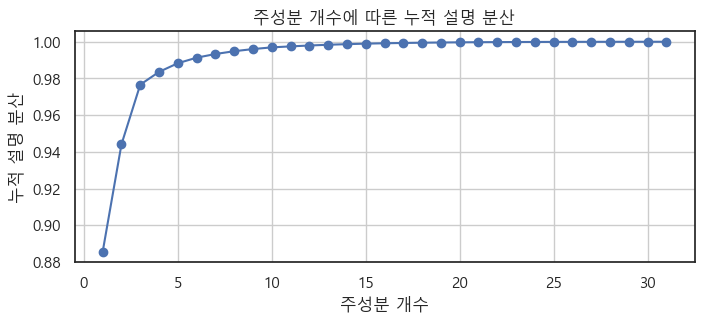

In [55]:
plt.figure(figsize=(8,3))
plt.plot(num_components, cumulative_variance, marker='o', linestyle='-')
plt.title('주성분 개수에 따른 누적 설명 분산')
plt.xlabel('주성분 개수')
plt.ylabel('누적 설명 분산')
plt.grid(True)
plt.show()
# 주성분 3개일때 데이터셋 98% 이상 설명

### 2-3. K means Clustering

In [ ]:
# K-means Clustering
ks = range(1, 20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init=5)
    %time model.fit(bank2[adj_cols])
    inertias.append(model.inertia_)
    print('n_cluster : {}, inertia : {}'.format(k, model.inertia_))
    
plt.figure(figsize=(10,5))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [58]:
# 실루엣 계수 검증
silhouette_scores = []
k_range = range(2, 11)  
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bank2[adj_cols])
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_pca, labels)
    silhouette_scores.append(silhouette_avg)

optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]

In [59]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(bank2[adj_cols])

silhouette_avg = silhouette_score(bank2[adj_cols], kmeans.labels_)

# 결과를 출력합니다.
print(f'optimal_k = {optimal_k} 일 때의 실루엣 계수: {silhouette_avg:.2f}')

optimal_k = 3 일 때의 실루엣 계수: 0.44


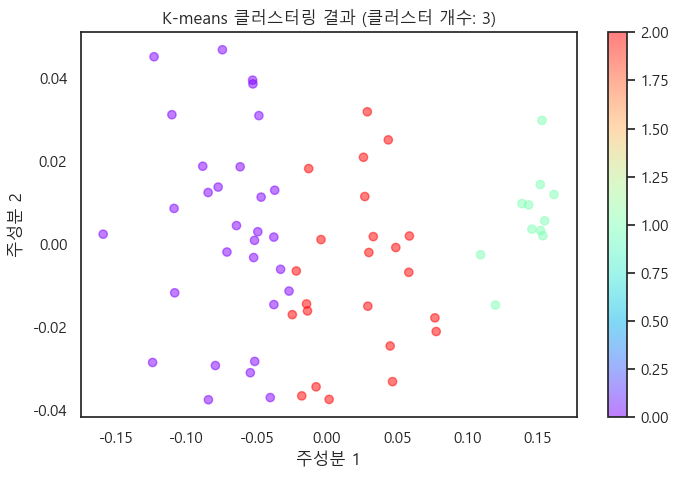

In [60]:
plt.figure(figsize=(8,5))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, 
            cmap='rainbow', marker='o', alpha=0.5)
plt.title(f'K-means 클러스터링 결과 (클러스터 개수: {optimal_k})')
plt.xlabel('주성분 1')
plt.ylabel('주성분 2')
plt.colorbar()
plt.show()

In [ ]:
# K-means Clustering
ks = range(1, 20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init=5)
    %time model.fit(bank2[adj_cols])
    inertias.append(model.inertia_)
    print('n_cluster : {}, inertia : {}'.format(k, model.inertia_))
    
plt.figure(figsize=(10,5))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

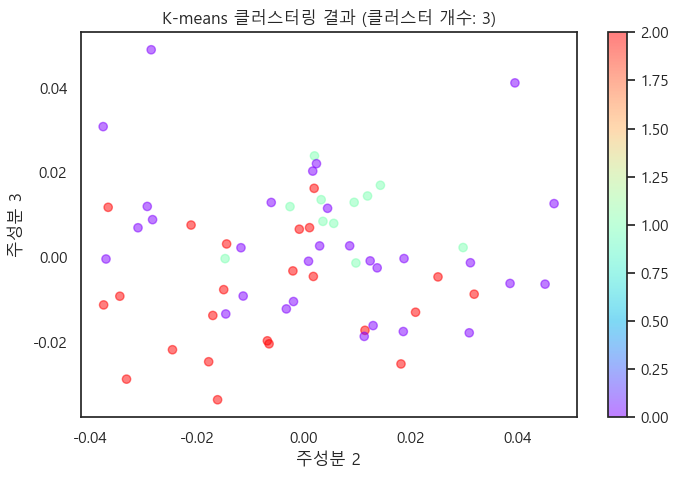

In [61]:
plt.figure(figsize=(8,5))
plt.scatter(df_pca[:, 1], df_pca[:, 2], c=kmeans.labels_, 
            cmap='rainbow', marker='o', alpha=0.5)
plt.title(f'K-means 클러스터링 결과 (클러스터 개수: {optimal_k})')
plt.xlabel('주성분 2')
plt.ylabel('주성분 3')
plt.colorbar()
plt.show()

In [62]:
bank2['cluster'] = kmeans.labels_ + 1
bank2.head()

,group,ba03r,ba04m,ba08m,ba09r,ba10m,ba11r,ba12m,ba13r,ba14m,...,bd12m,bd14m,bd16m,bd18m,bd19r,bd20m,bd22m,bd28m,bd30m,cluster
0,F 20e경기,0.001277,0.004721,0.037824,0.047792,0.002422,0.018636,0.019508,0.038203,0.009260,...,0.011036,0.046056,0.012163,0.014423,0.004784,0.002534,0.006001,0.003869,0.013744,3
1,F 20e광주,0.001515,0.002547,0.032401,0.032485,0.003461,0.013848,0.017446,0.019576,0.006554,...,0.011136,0.043367,0.011939,0.013097,0.003879,0.001035,0.003442,0.003634,0.011669,3
2,F 20e대구,0.001294,0.002586,0.032569,0.046436,0.002494,0.013865,0.024558,0.024645,0.007264,...,0.009598,0.043656,0.011864,0.013646,0.003032,0.000862,0.003020,0.003501,0.012356,3
3,F 20e대전,0.001181,0.001825,0.033995,0.035799,0.009591,0.016979,0.012371,0.026250,0.008597,...,0.009813,0.044330,0.011766,0.013529,0.006736,0.001132,0.003878,0.003374,0.012439,3
4,F 20e부산,0.001026,0.001041,0.033879,0.042906,0.002945,0.012650,0.011223,0.023878,0.007128,...,0.011514,0.044331,0.010997,0.013896,0.003056,0.000674,0.003275,0.003569,0.012377,3


In [63]:
bank2['cluster'].value_counts()

1    30
3    23
2    11
Name: cluster, dtype: int64

In [64]:
bank2.loc[bank2['cluster']==1]['group']

16    F 30e경기
17    F 30e광주
18    F 30e대구
19    F 30e대전
20    F 30e부산
21    F 30e서울
22    F 30e울산
23    F 30e인천
24    F 30s경기
25    F 30s광주
26    F 30s대구
29    F 30s서울
31    F 30s인천
37    M 20e서울
48    M 30e경기
49    M 30e광주
50    M 30e대구
51    M 30e대전
52    M 30e부산
53    M 30e서울
54    M 30e울산
55    M 30e인천
56    M 30s경기
57    M 30s광주
58    M 30s대구
59    M 30s대전
60    M 30s부산
61    M 30s서울
62    M 30s울산
63    M 30s인천
Name: group, dtype: object

In [65]:
bank2.loc[bank2['cluster']==2]['group']

9     F 20s광주
10    F 20s대구
11    F 20s대전
12    F 20s부산
14    F 20s울산
41    M 20s광주
42    M 20s대구
43    M 20s대전
44    M 20s부산
45    M 20s서울
46    M 20s울산
Name: group, dtype: object

In [66]:
bank2.loc[bank2['cluster']==3]['group']

0     F 20e경기
1     F 20e광주
2     F 20e대구
3     F 20e대전
4     F 20e부산
5     F 20e서울
6     F 20e울산
7     F 20e인천
8     F 20s경기
13    F 20s서울
15    F 20s인천
27    F 30s대전
28    F 30s부산
30    F 30s울산
32    M 20e경기
33    M 20e광주
34    M 20e대구
35    M 20e대전
36    M 20e부산
38    M 20e울산
39    M 20e인천
40    M 20s경기
47    M 20s인천
Name: group, dtype: object

- 특징 구별 우선 변수
    - bb08m 주택대출평잔, bb06m 신용대출평잔
    - ba09r bb08m
    - ba08m 예금평잔

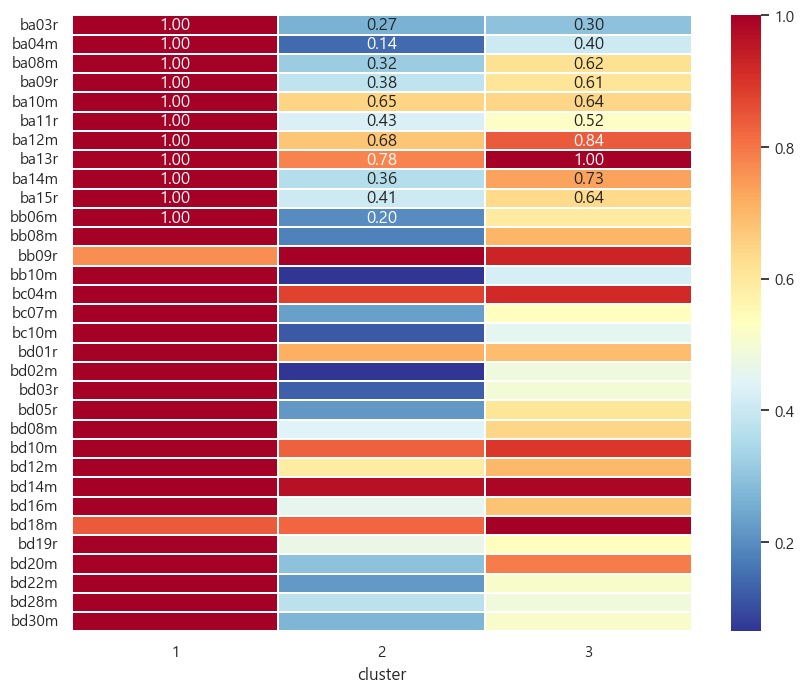

In [67]:
# 클러스터별 특징 파악
temp = bank2.groupby(['cluster']).mean(numeric_only=True)
cluster_mean = temp.transpose()
mean_table = cluster_mean.div(cluster_mean.max(axis=1), axis=0)

plt.figure(figsize=(10,8))
annot_kws = {'fontsize':12}
sns.heatmap(mean_table, annot=True, fmt='.2f',
           linewidths=0.1, annot_kws=annot_kws,
           cmap='RdYlBu_r')
plt.show()

In [68]:
mean_table

cluster,1,2,3
ba03r,1.000000,0.265463,0.297456
ba04m,1.000000,0.141418,0.404512
ba08m,1.000000,0.318986,0.616566
ba09r,1.000000,0.381803,0.609425
ba10m,1.000000,0.645941,0.643815
ba11r,1.000000,0.428958,0.524228
ba12m,1.000000,0.675096,0.841617
ba13r,0.995983,0.777200,1.000000
ba14m,1.000000,0.363071,0.734862
ba15r,1.000000,0.405894,0.637103


In [69]:
merged_df2 = bank.merge(bank2[['group','cluster']], on=['group'], how='left')
merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45840 entries, 0 to 45839
Data columns (total 87 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pk1      45840 non-null  int64  
 1   pk2      45840 non-null  object 
 2   pk3      45840 non-null  object 
 3   pk4      45840 non-null  object 
 4   ba01m    45840 non-null  int64  
 5   ba02m    45840 non-null  int64  
 6   ba03r    45840 non-null  float64
 7   ba04m    45840 non-null  int64  
 8   ba05r    45840 non-null  float64
 9   ba06m    45840 non-null  int64  
 10  ba07r    45840 non-null  float64
 11  ba08m    45840 non-null  int64  
 12  ba09r    45840 non-null  float64
 13  ba10m    45840 non-null  int64  
 14  ba11r    45840 non-null  float64
 15  ba12m    45840 non-null  int64  
 16  ba13r    45840 non-null  float64
 17  ba14m    45840 non-null  int64  
 18  ba15r    45840 non-null  float64
 19  ba16m    45840 non-null  int64  
 20  ba17r    45840 non-null  float64
 21  ba18m    458

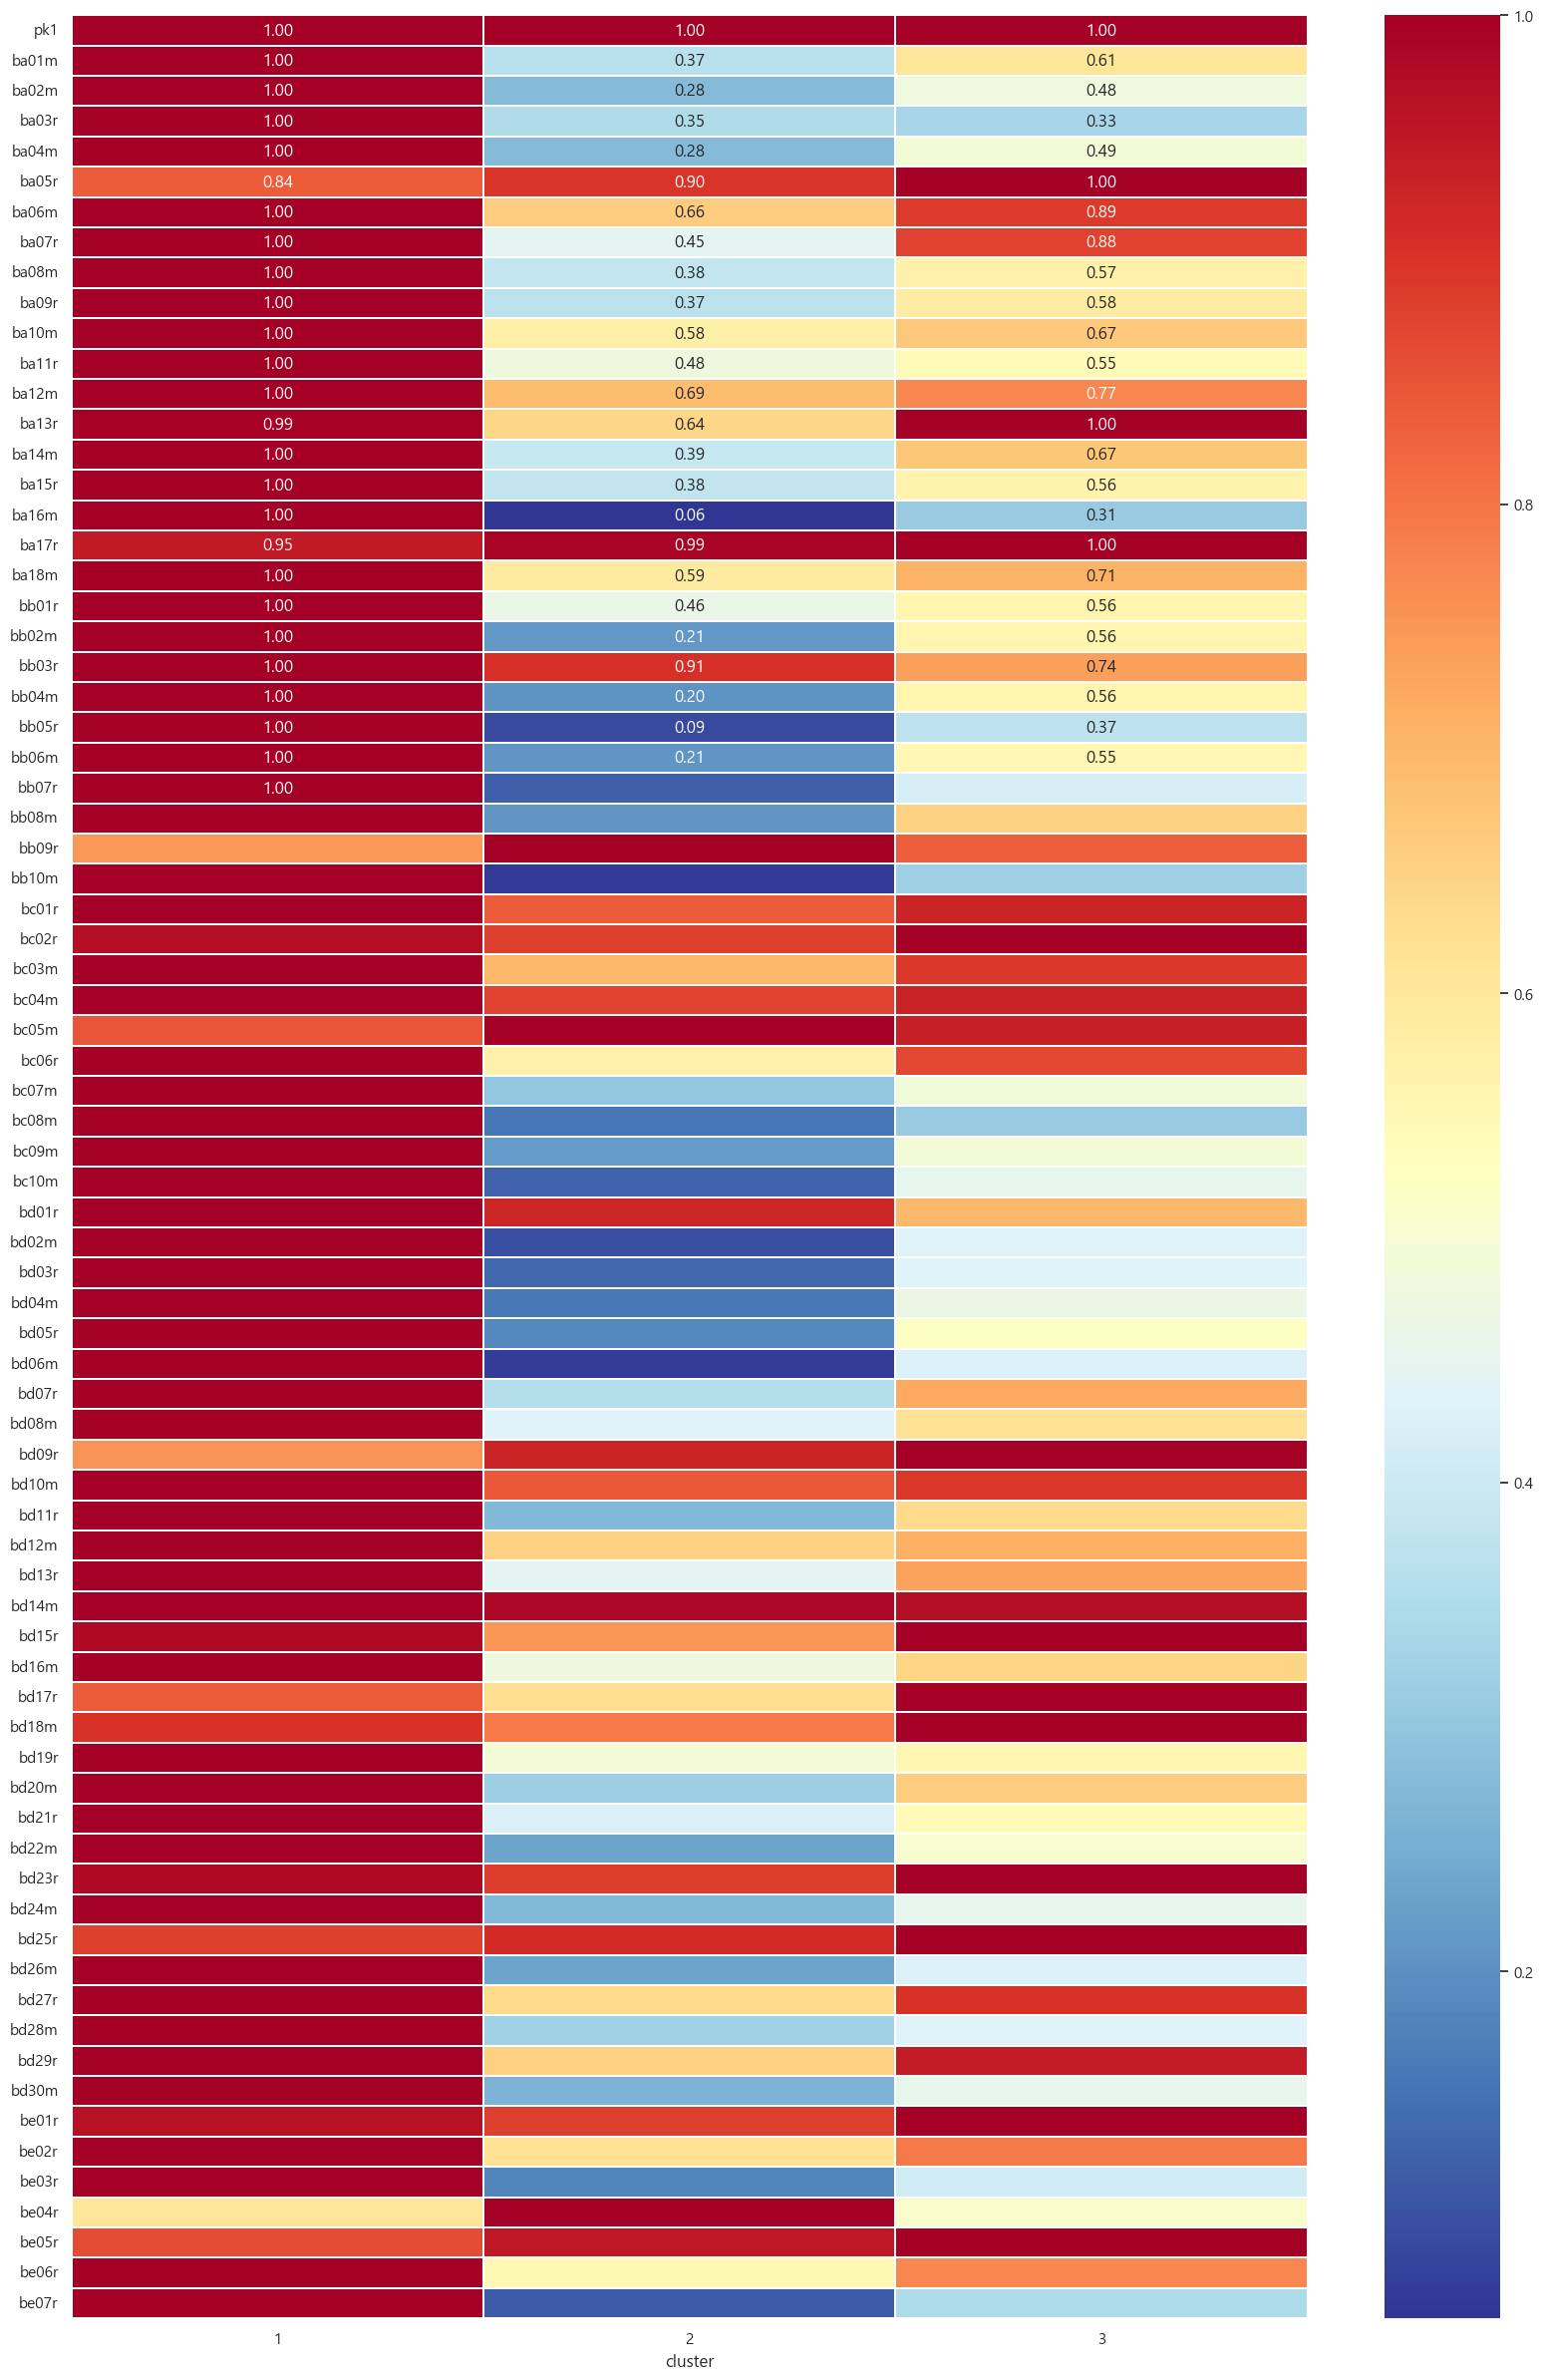

In [70]:
temp = merged_df2.groupby(['cluster']).mean(numeric_only=True)
cluster_mean = temp.transpose()
mean_table = cluster_mean.div(cluster_mean.max(axis=1), axis=0)

plt.figure(figsize=(20,30))
annot_kws = {'fontsize':12}
sns.heatmap(mean_table, annot=True, fmt='.2f',
           linewidths=0.1, annot_kws=annot_kws,
           cmap='RdYlBu_r')
plt.show()

In [78]:
box = merged_df2.groupby('group').mean()

<Axes: xlabel='bc02r', ylabel='cluster'>

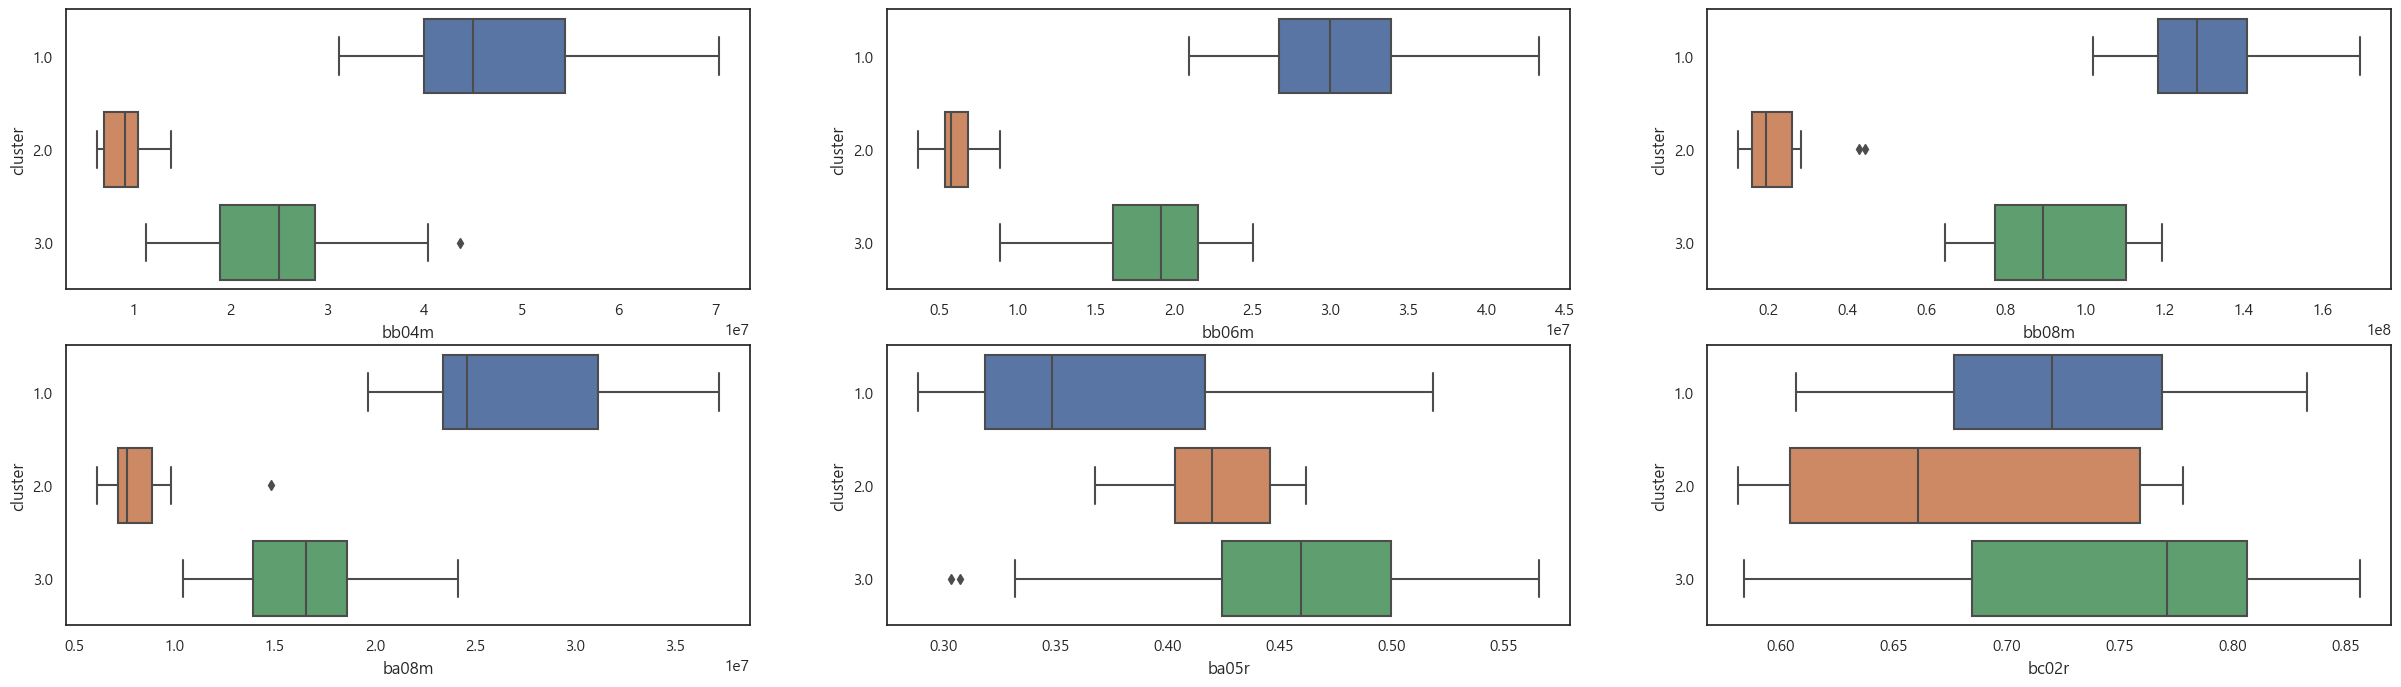

In [80]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(30,8)

sns.boxplot(data=box, y='cluster', x='bb04m', orient='h', ax=ax1) # 일반대출평잔
sns.boxplot(data=box, y='cluster', x='bb06m', orient='h', ax=ax2) # 신용대출평잔
sns.boxplot(data=box, y='cluster', x='bb08m', orient='h', ax=ax3) # 주택대출평잔
sns.boxplot(data=box, y='cluster', x='ba08m', orient='h', ax=ax4) # 예금평잔
sns.boxplot(data=box, y='cluster', x='ba05r', orient='h', ax=ax5) # 적금계좌보유비율
sns.boxplot(data=box, y='cluster', x='bc02r', orient='h', ax=ax6) # SOL 이용비율

<Axes: xlabel='bd09r', ylabel='cluster'>

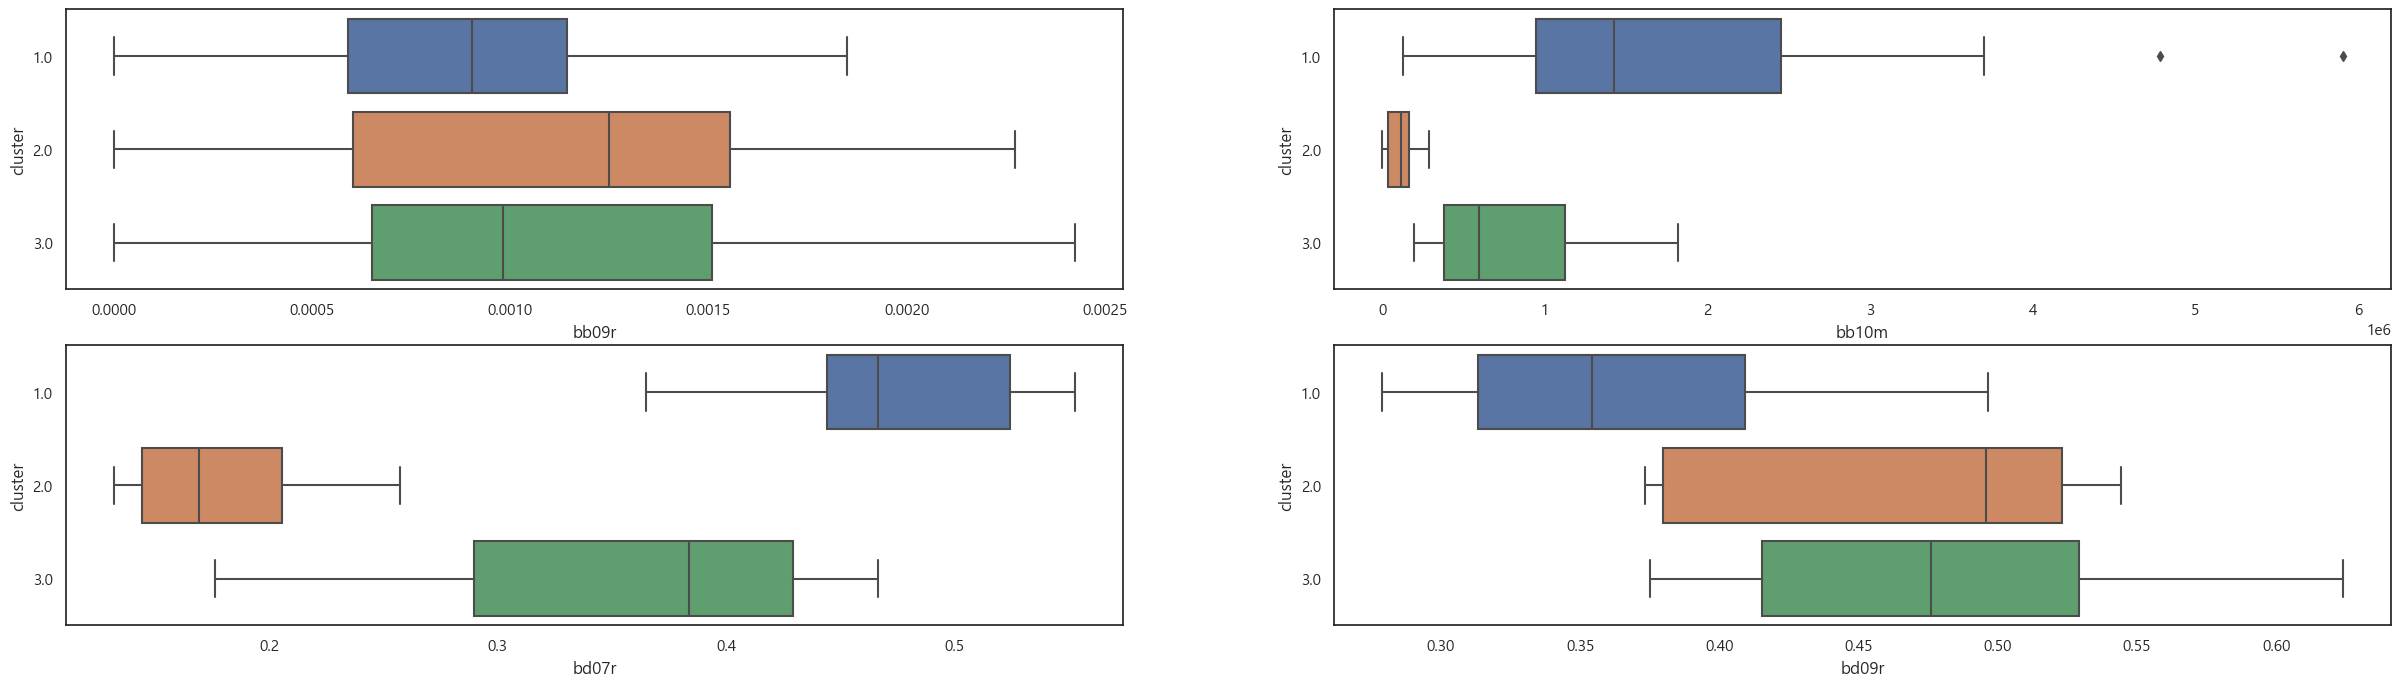

In [81]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(30,8)

sns.boxplot(data=box, y='cluster', x='bb09r', orient='h', ax=ax1) # 종합통장대출계좌보유비율
sns.boxplot(data=box, y='cluster', x='bb10m', orient='h', ax=ax2) # 종합통장대출한도금액
sns.boxplot(data=box, y='cluster', x='bd07r', orient='h', ax=ax3) # 신용카드 비율
sns.boxplot(data=box, y='cluster', x='bd09r', orient='h', ax=ax4) # 체크카드 비율

## 3. 인자 분석을 통한 고객군별 맞춤 상품 제시

In [ ]:
cluster_all = merged_df2.copy()
cluster_all['cluster'] = cluster_all['cluster'].astype(str).str.rstrip('.0')
cluster_all['pk1'] = cluster_all['pk1'].astype(str)
cluster_all

In [ ]:
# cluster 분리
cluster1 = cluster_all.loc[cluster_all['cluster']=='1']
clu1_num = cluster1.select_dtypes(include=['number'])

cluster2 = cluster_all.loc[cluster_all['cluster']=='2']
clu2_num = cluster2.select_dtypes(include=['number'])

cluster3 = cluster_all.loc[cluster_all['cluster']=='3']
clu3_num = cluster3.select_dtypes(include=['number'])

In [ ]:
# 클러스터 1
# 상관행렬 계산, Scree Plot으로 고유값(eigen value) 계산, 요인개수 정하기
cor_matrix = clu1_num.corr()

# Scree Plot을 그리기 위한 고유값(eigenvalues) 계산
fa = FactorAnalyzer()
fa.fit(cor_matrix)
eigenvalues, _ = fa.get_eigenvalues()

# Scree Plot 그리기
plt.figure(figsize=(8,3))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('요인 번호')
plt.ylabel('고유값(Eigenvalue)')
plt.grid(True)
plt.show()

In [ ]:
# Bartlett의 테스트
chi_square_value, p_value = calculate_bartlett_sphericity(clu1_num)
print("Bartlett's Test:")
print("Chi-Square Value:", chi_square_value)
print("P-Value:", p_value)

In [ ]:
# KMO 통계량: 0.874
kmo1, kmo_model = calculate_kmo(clu1_num)
print("\nKMO Statistics:")
print("KMO Overall:", kmo1)
print("KMO Model:", kmo_model)

In [ ]:
# 요인 분석 모델 생성
fa = FactorAnalyzer(n_factors=5, rotation="varimax")  
fa.fit(clu1_num)

In [ ]:
# 요인적재값 출력
factor_loadings = fa.loadings_

# 요인 분석 결과 요약
eigenvalues, eigenvectors = fa.get_eigenvalues()

In [ ]:
# Heatmap을 그리기 위해 데이터프레임 생성
factor_names = [f"Factor{i+1}" for i in range(factor_loadings.shape[1])]
variable_names = clu1_num.columns
factor_loadings_df = pd.DataFrame(data=factor_loadings, columns=factor_names, index=variable_names)

# Heatmap 그리기
plt.figure(figsize=(10, 20))
sns.heatmap(factor_loadings_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Factor Loadings Heatmap')
plt.xlabel('Factors')
plt.ylabel('Variables')
plt.show()

In [ ]:
# 클러스터 2
# 상관행렬 계산, Scree Plot으로 고유값(eigen value) 계산, 요인개수 정하기
cor_matrix = clu2_num.corr()

# Scree Plot을 그리기 위한 고유값(eigenvalues) 계산
fa = FactorAnalyzer()
fa.fit(cor_matrix)
eigenvalues, _ = fa.get_eigenvalues()

# Scree Plot 그리기
plt.figure(figsize=(8,3))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('요인 번호')
plt.ylabel('고유값(Eigenvalue)')
plt.grid(True)
plt.show()

In [ ]:
# Bartlett의 테스트
chi_square_value, p_value = calculate_bartlett_sphericity(clu2_num)
print("Bartlett's Test:")
print("Chi-Square Value:", chi_square_value)
print("P-Value:", p_value)

# KMO 통계량: 0.731
kmo, kmo_model = calculate_kmo(clu2_num)
print("\nKMO Statistics:")
print("KMO Overall:", kmo)
print("KMO Model:", kmo_model)

In [ ]:
# 요인 분석 모델 생성
fa = FactorAnalyzer(n_factors=4, rotation="varimax")  
fa.fit(clu2_num)

# 요인적재값 출력
factor_loadings = fa.loadings_

# 요인 분석 결과 요약
eigenvalues, eigenvectors = fa.get_eigenvalues()

In [ ]:
# Heatmap을 그리기 위해 데이터프레임 생성
factor_names = [f"Factor{i+1}" for i in range(factor_loadings.shape[1])]
variable_names = clu2_num.columns
factor_loadings_df = pd.DataFrame(data=factor_loadings, columns=factor_names, index=variable_names)

# Heatmap 그리기
plt.figure(figsize=(10, 20))
sns.heatmap(factor_loadings_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Factor Loadings Heatmap')
plt.xlabel('Factors')
plt.ylabel('Variables')
plt.show()

In [ ]:
# 클러스터 3
# 상관행렬 계산, Scree Plot으로 고유값(eigen value) 계산, 요인개수 정하기
cor_matrix = clu3_num.corr()

# Scree Plot을 그리기 위한 고유값(eigenvalues) 계산
fa = FactorAnalyzer()
fa.fit(cor_matrix)
eigenvalues, _ = fa.get_eigenvalues()

# Scree Plot 그리기
plt.figure(figsize=(8,3))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('요인 번호')
plt.ylabel('고유값(Eigenvalue)')
plt.grid(True)
plt.show()

In [ ]:
# Bartlett의 테스트
chi_square_value, p_value = calculate_bartlett_sphericity(clu3_num)
print("Bartlett's Test:")
print("Chi-Square Value:", chi_square_value)
print("P-Value:", p_value)

# KMO 통계량: 0.854
kmo, kmo_model = calculate_kmo(clu3_num)
print("\nKMO Statistics:")
print("KMO Overall:", kmo)
print("KMO Model:", kmo_model)

In [ ]:
# 요인 분석 모델 생성
fa = FactorAnalyzer(n_factors=4, rotation="varimax")  
fa.fit(clu3_num)

# 요인적재값 출력
factor_loadings = fa.loadings_

# 요인 분석 결과 요약
eigenvalues, eigenvectors = fa.get_eigenvalues()

In [ ]:
# Heatmap을 그리기 위해 데이터프레임 생성
factor_names = [f"Factor{i+1}" for i in range(factor_loadings.shape[1])]
variable_names = clu3_num.columns
factor_loadings_df = pd.DataFrame(data=factor_loadings, columns=factor_names, index=variable_names)

# Heatmap 그리기
plt.figure(figsize=(10, 20))
sns.heatmap(factor_loadings_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Factor Loadings Heatmap')
plt.xlabel('Factors')
plt.ylabel('Variables')
plt.show()

## 3. 고객군별 카드 소비 패턴 파악

**신한카드**
- 이용건수: 'ce18m', 'ce19m', 'ce20m', 'cg23m', 'cg24m', 'cg25m', 'cg44m',
- 이용금액: 'ce03m', 'ce04m', 'ce05m', 'cg01m', 'cg02m', 'cg03m', 'cg22m'
- 면세점: 이용건수'cc18m', 이용금액'cc05m'
- 통신요금: 이용건수'ce21m', 이용금액'ce06m'
- 렌터카: 이용비율'ce42r'

**신한증권**
- 해외주식 거래 경험 비율: 'sa03r'
- 고객 가치등급_1~5등급 고객 비율: 'sc06r ~ sc10r'

In [ ]:
card2 = card[['group', 'ce18m', 'ce19m', 'ce20m', 'cg23m', 'cg24m', 'cg25m', 'cg44m',
             'ce03m', 'ce04m', 'ce05m', 'cg01m', 'cg02m', 'cg03m', 'cg22m',
            'cc18m', 'cc05m', 'ce21m', 'ce06m', 'ce42r']]

In [ ]:
card2['cluster'] = merged_df2['cluster']
card2['cluster'] = card2['cluster'].astype(str).str.rstrip('.0')

In [ ]:
cluster = card2.groupby('cluster', as_index=False).mean()
cluster = cluster[cluster['cluster'] != 'nan']
cluster

In [ ]:
# 건수 대비 금액
cluster['항공'] = cluster['ce03m'] / card2['ce18m']
cluster['철도'] = cluster['ce04m'] / card2['ce19m']
cluster['여객선'] = cluster['ce05m'] / card2['ce20m']
cluster['특급호텔'] = card2['cg01m'] / card2['cg23m']
cluster['숙박'] = card2['cg02m'] / card2['cg24m']
cluster['여행사'] = card2['cg03m'] / card2['cg25m']
cluster['해외여행직구'] = card2['cg22m'] / card2['cg44m']

card2['면세점'] = card2['cc05m'] / card2['cc18m']
card2['통신요금'] = card2['ce06m'] / card2['ce21m']
card2['렌터카'] = card2['ce42r']

In [ ]:
sel_columns = ['항공', '철도', '여객선', '특급호텔', '숙박', '여행사', '해외여행직구',
              '면세점' ,'통신요금', '렌터카']

In [ ]:
# 각 컬럼에 대한 바차트 그리기
for col in sel_columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=col, y='cluster', data=cluster, orient='h')

    # 그래프 타이틀과 레이블 추가
    plt.title(f'{col} Bar Chart')
    plt.xlabel(col)
    plt.ylabel('Cluster')

    plt.show()

In [ ]:
cluster

In [ ]:
# 각 컬럼에 대한 바차트 그리기
for col in sel_columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=col, y='cluster', data=cluster, orient='h')

    # 그래프 타이틀과 레이블 추가
    plt.title(f'{col} Bar Chart')
    plt.xlabel(col)
    plt.ylabel('Cluster')

    plt.show()

In [ ]:
invest2 = invest[['group','sa03r','sc06r','sc07r','sc08r','sc09r','sc10r']]
invest2['cluster'] = merged_df2['cluster']
invest2['cluster'] = invest2['cluster'].astype(str).str.rstrip('.0')
invest2

In [ ]:
cluster2 = invest2.groupby('cluster', as_index=False).mean()
cluster2 = cluster2[cluster2['cluster'] != 'nan']
cluster2

In [ ]:
invest2

In [ ]:
figure, ((ax1, ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(30,8)

sns.boxplot(data=invest2, y='cluster', x='sc06r', orient='h', ax=ax1)
sns.boxplot(data=invest2, y='cluster', x='sc07r', orient='h', ax=ax2) 
sns.boxplot(data=invest2, y='cluster', x='sc08r', orient='h', ax=ax3)
sns.boxplot(data=invest2, y='cluster', x='sc09r', orient='h', ax=ax4) 
sns.boxplot(data=invest2, y='cluster', x='sc10r', orient='h', ax=ax4)

In [ ]:
sel_columns = ['sa03r', 'sc06r', 'sc07r', 'sc08r', 'sc09r', 'sc10r']
# 각 컬럼에 대한 바차트 그리기
for col in sel_columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=col, y='cluster', data=cluster2, orient='h')

    # 그래프 타이틀과 레이블 추가
    plt.title(f'{col} Bar Chart')
    plt.xlabel(col)
    plt.ylabel('Cluster')

    plt.show()